In [90]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [91]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [85]:
cutoff_date = '2022-05-31' ## len = 65, 월별 마지막 일자 잘 맞춰 줘야 함
test_period = 7 ## 예측 기간 (월)
corr_rate = 0.9 ## Lag corr rate

## <원 data set>

In [86]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [87]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(10,13):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

KeyboardInterrupt: 

In [88]:
raw_y_set_shifted_merged

,date,y,y_11,y_12,y_13,y2,y2_11,y2_12,y2_13,Baltic Dry Index (BDI),...,ERAMET(ERA.PA)_Close_12,ERAMET(ERA.PA)_Close_13,ERAMET(ERA.PA)_Adj Close,ERAMET(ERA.PA)_Adj Close_11,ERAMET(ERA.PA)_Adj Close_12,ERAMET(ERA.PA)_Adj Close_13,Lundin Mining(LUN.TO)_Open,Lundin Mining(LUN.TO)_Open_11,Lundin Mining(LUN.TO)_Open_12,Lundin Mining(LUN.TO)_Open_13
0,2016-01-31,20.177268,NaN,NaN,NaN,20.680110,NaN,NaN,NaN,386.300000,...,NaN,NaN,21.652791,NaN,NaN,NaN,3.335500,NaN,NaN,NaN
1,2016-02-29,23.306868,NaN,NaN,NaN,24.462716,NaN,NaN,NaN,306.904762,...,NaN,NaN,16.932949,NaN,NaN,NaN,3.504000,NaN,NaN,NaN
2,2016-03-31,25.223010,NaN,NaN,NaN,28.364874,NaN,NaN,NaN,383.333333,...,NaN,NaN,22.360672,NaN,NaN,NaN,4.183182,NaN,NaN,NaN
3,2016-04-30,25.308243,NaN,NaN,NaN,29.181978,NaN,NaN,NaN,607.476191,...,NaN,NaN,24.981643,NaN,NaN,NaN,4.217143,NaN,NaN,NaN
4,2016-05-31,24.875099,NaN,NaN,NaN,27.810405,NaN,NaN,NaN,619.900000,...,NaN,NaN,27.587567,NaN,NaN,NaN,4.220952,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2022-01-31,43.260870,7.761364,6.940476,6.750000,38.652174,9.227273,9.000000,9.000000,1760.800000,...,45.526000,40.784091,83.810633,52.861635,44.744839,40.084294,10.447500,13.356316,11.763500,10.247619
73,2022-02-28,56.425000,9.663043,7.761364,6.940476,51.862500,10.869565,9.227273,9.000000,1834.900000,...,53.784500,45.526000,103.090237,56.726189,52.861635,44.744839,11.484211,14.003478,13.356316,11.763500
74,2022-03-31,71.086957,11.326087,9.663043,7.761364,69.576087,12.097826,10.869565,9.227273,2464.086957,...,57.716522,53.784500,131.760578,58.769003,56.726189,52.861635,12.527391,14.631429,14.003478,13.356316
75,2022-04-30,75.804348,12.727273,11.326087,9.663043,81.173913,13.147727,12.097826,10.869565,2220.368421,...,59.795000,57.716522,143.334491,60.908089,58.769003,56.726189,12.804500,14.080000,14.631429,14.003478


#### 해당 기간에서의 12{test_period} lag corr best

In [89]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y')==False]
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y2')==False]
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]

raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]

raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.strip(f'_{test_period}') for word in futr_list ]

# futr_list.remove('y')
# futr_list.remove('y2')

futr_list

KeyError: "['Lundin Mining(LUN.TO)_High', 'Lundin Mining(LUN.TO)_Low', 'Lundin Mining(LUN.TO)_Close', 'Lundin Mining(LUN.TO)_Adj Close', 'Cameco(CCJ)_Open', 'Cameco(CCJ)_High', 'Cameco(CCJ)_Low', 'Cameco(CCJ)_Close', 'Cameco(CCJ)_Adj Close', 'Rio Tinto(RIO)_Open_x', 'Rio Tinto(RIO)_High_x', 'Rio Tinto(RIO)_Low_x', 'Rio Tinto(RIO)_Close_x', 'Rio Tinto(RIO)_Adj Close_x', 'Rio Tinto(RIO)_Open_y', 'Rio Tinto(RIO)_High_y', 'Rio Tinto(RIO)_Low_y', 'Rio Tinto(RIO)_Close_y', 'Rio Tinto(RIO)_Adj Close_y', 'First Quantum (FM.TO)_Open', 'First Quantum (FM.TO)_High', 'First Quantum (FM.TO)_Low', 'First Quantum (FM.TO)_Close', 'First Quantum (FM.TO)_Adj Close', 'Barrick Gold(GOLD)_Open', 'Barrick Gold(GOLD)_High', 'Barrick Gold(GOLD)_Low', 'Barrick Gold(GOLD)_Close', 'Barrick Gold(GOLD)_Adj Close', 'FRANCO NEVADA(FNV)_Open', 'FRANCO NEVADA(FNV)_High', 'FRANCO NEVADA(FNV)_Low', 'FRANCO NEVADA(FNV)_Close', 'FRANCO NEVADA(FNV)_Adj Close', 'African Rainbow(AFBOF)_Open', 'African Rainbow(AFBOF)_High', 'African Rainbow(AFBOF)_Low', 'African Rainbow(AFBOF)_Close', 'African Rainbow(AFBOF)_Adj Close', 'Anglo Plat(ANGPY)_Open', 'Anglo Plat(ANGPY)_High', 'Anglo Plat(ANGPY)_Low', 'Anglo Plat(ANGPY)_Close', 'Anglo Plat(ANGPY)_Adj Close', 'XSTRATA(Glencore plc (GLNCY))_Open', 'XSTRATA(Glencore plc (GLNCY))_High', 'XSTRATA(Glencore plc (GLNCY))_Low', 'XSTRATA(Glencore plc (GLNCY))_Close', 'XSTRATA(Glencore plc (GLNCY))_Adj Close', 'Anglo American plc (NGLOY)_Open', 'Anglo American plc (NGLOY)_High', 'Anglo American plc (NGLOY)_Low', 'Anglo American plc (NGLOY)_Close', 'Anglo American plc (NGLOY)_Adj Close', 'BHP Group (BHP)_Open', 'BHP Group (BHP)_High', 'BHP Group (BHP)_Low', 'BHP Group (BHP)_Close', 'BHP Group (BHP)_Adj Close', 'SQM_price_Open', 'SQM_price_High', 'SQM_price_Low', 'SQM_price_Close', 'SQM_price_Adj Close', 'ALB_price_Open', 'ALB_price_High', 'ALB_price_Low', 'ALB_price_Close', 'ALB_price_Adj Close', 'LAC_price_Open', 'LAC_price_High', 'LAC_price_Low', 'LAC_price_Close', 'LAC_price_Adj Close', '1772.HK(Ganfeng Lithium)_Price_Open', '1772.HK(Ganfeng Lithium)_Price_High', '1772.HK(Ganfeng Lithium)_Price_Low', '1772.HK(Ganfeng Lithium)_Price_Close', '1772.HK(Ganfeng Lithium)_Price_Adj Close', '002466.SZ(Tianqi Lithium)_price_Open', '002466.SZ(Tianqi Lithium)_price_High', '002466.SZ(Tianqi Lithium)_price_Low', '002466.SZ(Tianqi Lithium)_price_Close', '002466.SZ(Tianqi Lithium)_price_Adj Close', 'independence group_price_Open', 'independence group_price_High', 'independence group_price_Low', 'independence group_price_Close', 'independence group_price_Adj Close', 'Livent Corporation_price_Open', 'Livent Corporation_price_High', 'Livent Corporation_price_Low', 'Livent Corporation_price_Close', 'Livent Corporation_price_Adj Close', 'Orocobre Limited (OROCF)_price_Open', 'Orocobre Limited (OROCF)_price_High', 'Orocobre Limited (OROCF)_price_Low', 'Orocobre Limited (OROCF)_price_Close', 'Orocobre Limited (OROCF)_price_Adj Close', 'Pilbara Mineral Limited_price_Open', 'Pilbara Mineral Limited_price_High', 'Pilbara Mineral Limited_price_Low', 'Pilbara Mineral Limited_price_Close', 'Pilbara Mineral Limited_price_Adj Close', 'Allkem Limited (AKE.AX)_price_Open', 'Allkem Limited (AKE.AX)_price_High', 'Allkem Limited (AKE.AX)_price_Low', 'Allkem Limited (AKE.AX)_price_Close', 'Allkem Limited (AKE.AX)_price_Adj Close'] not in index"

In [ ]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

#### 해당 기간에서의 12{test_period} corr best

In [84]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_var_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 'CPI_PRT_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량',
 'CPI_GBR_TOT_FOODENRG_AGRWTH',
 'CPI_TUR_ENRG_AGRWTH',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 'CPI_LTU_TOT_AGRWTH',
 'CPI_GRC_TOT_AGRWTH',
 'CPI_DNK_ENRG_IDX2015',
 'CPI_LTU_FOOD_AGRWTH',
 'CPI_GRC_ENRG_IDX2015',
 'CPI_OECD_TOT_FOODENRG_AGRWTH',
 'CPI_BEL_TOT_FOODENRG_AGRWTH',
 'CPI_DNK_TOT_AGRWTH',
 'HOUSECOST_KOR',
 'CPI_EST_TOT_FOODENRG_AGRWTH',
 'CPI_EST_TOT_AGRWTH',
 'PPP_POL',
 'CPI_BEL_ENRG_AGRWTH',
 'CPI_GRC_ENRG_AGRWTH',
 'CPI_KOR_TOT_FOODENRG_AGRWTH',
 'Pilbara Mineral Limited_price_Adj Close',
 'CPI_GBR_TOT_AGRWTH',
 'CPI_ESP_TOT_FOODENRG_AGRWTH',
 'CPI_SWE_TOT_AGRWTH',
 'CPI_NLD_ENRG_AGRWTH',
 'CPI_CHL_TOT_AGRWTH',
 'CPI_OECDE_TOT_AGRWTH',
 'CPI_ITA_TOT_AGRWTH',
 'CPI_OECDE_TOT_FOODENRG_AGRWTH',
 'CPI_LTU_ENRG_IDX2015',
 'CPI_TUR_TOT_AGRWTH',
 'CPI_CAN_TOT_FOODENRG_AGRWTH',
 'Shanghai Containerized Freight Index (SCFI)',
 'GDP_SAU',
 'C

## scasler

In [31]:
# df_tgt = df.iloc[:,3:]

# scaler = StandardScaler()
# scaler.fit(df_tgt)
# arr = scaler.transform(df_tgt)
# df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
# df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [32]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [33]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [34]:
# len(df.loc[df.ds<'2021-06-30'])

In [79]:
Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<cutoff_date])]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]][:test_period]

In [36]:
futr_list

[]

In [80]:
futr_temp = Y_test_df.drop(['y'], axis=1).copy()
# futr_list = [
#              'Shanghai Containerized Freight Index (SCFI)',
#              '대두 [미국(생산자 가격)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
#              # 'HOUSECOST_KOR'
#              ]
futr_date = futr_temp.iloc[:,:2].copy()
futr_df = pd.concat([futr_date,futr_temp[futr_list]], axis=1)
# futr_df

KeyError: "['African Rainbow(AFBOF)_Adj Close_11', '1772.HK(Ganfeng Lithium)_Price_Open_13', '1772.HK(Ganfeng Lithium)_Price_High_13', '1772.HK(Ganfeng Lithium)_Price_Low_13', '1772.HK(Ganfeng Lithium)_Price_Close_13', '1772.HK(Ganfeng Lithium)_Price_Adj Close_13', 'African Rainbow(AFBOF)_Adj Close_12', 'HOUSECOST_FIN_13', 'HOUSECOST_FIN_12', 'HOUSECOST_FIN_11', 'African Rainbow(AFBOF)_Adj Close_13', 'Cameco(CCJ)_High_11', 'Cameco(CCJ)_Open_11', 'Cameco(CCJ)_Close_11', '1772.HK(Ganfeng Lithium)_Price_Low_12', 'Cameco(CCJ)_Adj Close_11', '1772.HK(Ganfeng Lithium)_Price_Open_12', '1772.HK(Ganfeng Lithium)_Price_Close_12', '1772.HK(Ganfeng Lithium)_Price_Adj Close_12', '1772.HK(Ganfeng Lithium)_Price_High_12', 'Cameco(CCJ)_Low_11', 'CCI_SWE_11', '옥수수 For Grain [미국(생산자 가격)] 현물_11', 'Howe Robinson Container Index_11', 'LAC_price_Open_13', 'LAC_price_Low_13', 'LAC_price_High_13', 'LAC_price_Close_13', 'LAC_price_Adj Close_13', '1772.HK(Ganfeng Lithium)_Price_Low_11', '1772.HK(Ganfeng Lithium)_Price_Open_11', '1772.HK(Ganfeng Lithium)_Price_Close_11', 'Cameco(CCJ)_High_12', '1772.HK(Ganfeng Lithium)_Price_Adj Close_11', 'Cameco(CCJ)_Adj Close_12', '1772.HK(Ganfeng Lithium)_Price_High_11', 'Cameco(CCJ)_Open_12', 'Cameco(CCJ)_Close_12'] not in index"

#### No 변수

In [38]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'robust',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [39]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [40]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [41]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon + 1,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_var_list, #22년 3월부터는 안됌
                futr_exog_list = futr_list,
                # n_blocks = [1, 1, 1],
                # mlp_units = [[512, 512], [512, 512], [512, 512]],
                # n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                pooling_mode = 'MaxPool1d',
                scaler_type = 'robust',
                learning_rate=1e-4,
                activation='ReLU',
                batch_size=32,
                random_seed=42,
                max_epochs=200
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

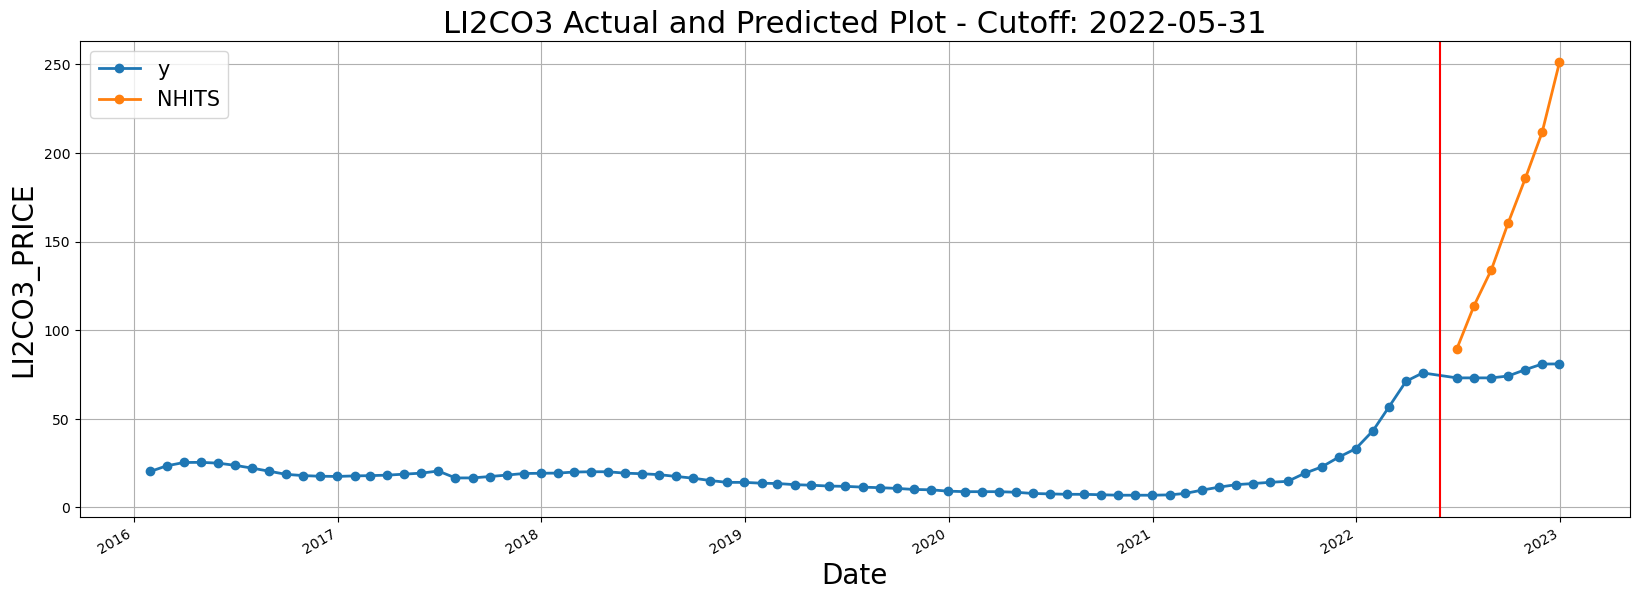

In [42]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [43]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)